# Answering Chinook Record Store's Business Questions
In this project, I have used SQL skills to answer business questions on the Chinook database.
Multiple Questions were taken into consideration while performing the analysis. Based on the analysis performed, a definitive conclusion was reached for several of these questions:
- Finding which genre sell the best in USA
- Analyzing Employee Sales Performance
- Analyzing Sales by Country
  - total number of customers
  - total value of sales
  - average value of sales per customer
  - average order value
- Selling Albums vs Individual Tracks  

In [2]:
import sqlite3 as sql
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
#creating helper functions
#function that accepts the SQL query as an argument and returns a pandas dataframe of that query

def run_query(q):
    with sql.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [4]:
#function that takes SQL command as an argument and execute it using sqlite module:

def run_command(c):
    with sql.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [5]:
#function that calls the run_query() function to return a list of all tables and views in the database:

def show_tables():
    q = """SELECT 
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");"""
    return run_query(q) 

In [6]:
show_tables()

name   type
0            album  table
1           artist  table
2         customer  table
3         employee  table
4            genre  table
5          invoice  table
6     invoice_line  table
7       media_type  table
8         playlist  table
9   playlist_track  table
10           track  table

# Selecting Albums to Purchase
Finding which genre sell the best in USA so that we can buy the albums accordingly

In [7]:
# query that returns each genre with number of tracks sold in USA
albums_to_purchase = """ WITH country_usa AS
            (
                SELECT il.* FROM invoice_line il 
                INNER JOIN invoice i ON il.invoice_id = i.invoice_id
                INNER JOIN customer c ON i.customer_id = c.customer_id
                WHERE c.country = "USA"
            ) 
            
         SELECT g.name genre,
                COUNT(cu.invoice_line_id) tracks_sold,
                CAST(COUNT(cu.invoice_line_id) AS FLOAT)/ (SELECT COUNT(*)  FROM country_usa) *100 percentage_sold
                FROM country_usa cu 
                INNER JOIN track t ON cu.track_id = t.track_id
                INNER JOIN genre g ON t.genre_id = g.genre_id
                GROUP BY 1
                ORDER BY 2 DESC
                LIMIT 10
    """   
run_query(albums_to_purchase)

genre  tracks_sold  percentage_sold
0                Rock          561        53.377735
1  Alternative & Punk          130        12.369172
2               Metal          124        11.798287
3            R&B/Soul           53         5.042816
4               Blues           36         3.425309
5         Alternative           35         3.330162
6               Latin           22         2.093245
7                 Pop           22         2.093245
8         Hip Hop/Rap           20         1.902950
9                Jazz           14         1.332065

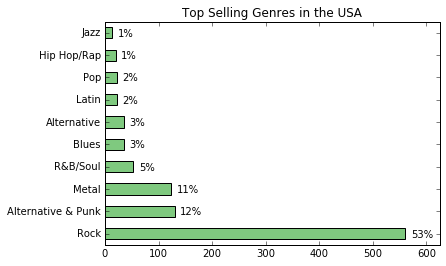

In [8]:
#creating a horizontal bar plot to analyze the results
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"]
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

- From the plot we found that 'Rock' is the most popular genre which makes more than 50% of the total sales in the USA followed by 'Alternative & Punk'.

- Whereas some of the genres like 'Jazz', 'Hip Hop' has a little contribution.

# Analyzing Employee Sales Performance
- This analysis will help in finding out if any sales support agent is performing either better or worse than the others

In [9]:
#query to find the employee sales performance
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

employee            hire_date  total_sales
0   Jane Peacock  2017-04-01 00:00:00      1731.51
1  Margaret Park  2017-05-03 00:00:00      1584.00
2  Steve Johnson  2017-10-17 00:00:00      1393.92

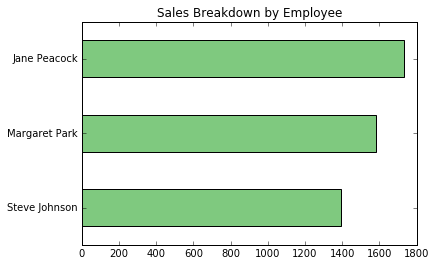

In [10]:
#plotting a horizontal bar graph to analyze the results
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

# Analyzing Sales by Country

Analyzing the following:

- total number of customers
- total value of sales
- average value of sales per customer
- average order value

Because there are a number of countries with only one customer, we should group these customers as "Other" in our analysis.

In [11]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

country  customers  total_sales  average_order  \
0             USA         13      1040.49       7.942672   
1          Canada          8       535.59       7.047237   
2          Brazil          5       427.68       7.011148   
3          France          5       389.07       7.781400   
4         Germany          4       334.62       8.161463   
5  Czech Republic          2       273.24       9.108000   
6  United Kingdom          3       245.52       8.768571   
7        Portugal          2       185.13       6.383793   
8           India          2       183.15       8.721429   
9           Other         15      1094.94       7.448571   

   customer_lifetime_value  
0                80.037692  
1                66.948750  
2                85.536000  
3                77.814000  
4                83.655000  
5               136.620000  
6                81.840000  
7                92.565000  
8                91.575000  
9                72.996000

# Visualizing Sales by Country

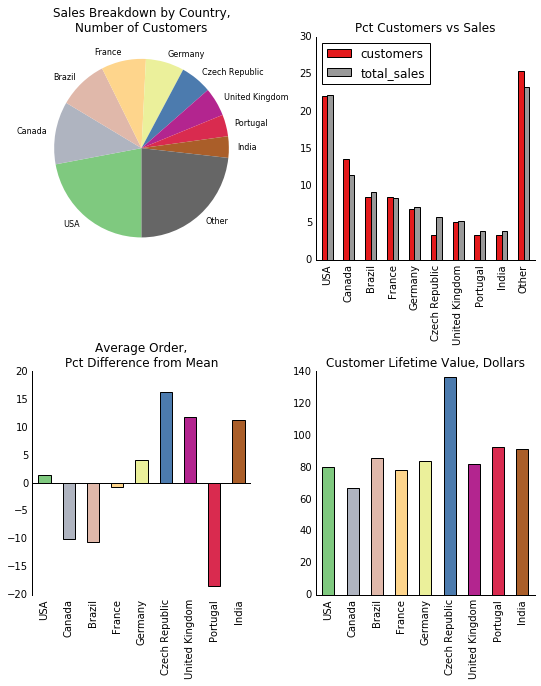

In [12]:
import numpy as np
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

# Albums vs Individual Tracks

In [13]:

albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

album_purchase  number_of_invoices   percent
0             no                 500  0.814332
1            yes                 114  0.185668

Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.